<a href="https://colab.research.google.com/github/olgasherbiena/KPI/blob/IDA/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

## Generate Data

In [58]:
dataset_path = kagglehub.dataset_download("albertobircoci/support-ticket-priority-dataset-50k")
support_ticket_data = pd.read_csv(os.path.join(dataset_path, "Support_tickets.csv"))

In [ ]:

numerical_features = ['customers_affected']
categorical_features = ['company_size_cat',  'region_cat', 'customer_tier_cat']
y_text = support_ticket_data['priority_cat']
le = LabelEncoder()
y_encoded = le.fit_transform(support_ticket_data['priority_cat'])
priorities = le.classes_ # ['High', 'Low', 'Medium']
colors = ['tab:red', 'tab:green', 'tab:blue']
preprocessor = ColumnTransformer(
    transformers=[
        ('num',
         Pipeline([('imputer', SimpleImputer(strategy='mean')),
                   ('scaler', StandardScaler())]),
         numerical_features),
        ('cat',
         Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]),
         categorical_features)
    ],
    remainder='drop'
)
X = support_ticket_data[numerical_features + categorical_features].copy()
X_scaled = preprocessor.fit_transform(X)

print(f"Матриця X_scaled успішно створена. Розмірність: {X_scaled.shape}")

Матриця X_scaled успішно створена. Розмірність: (50000, 10)


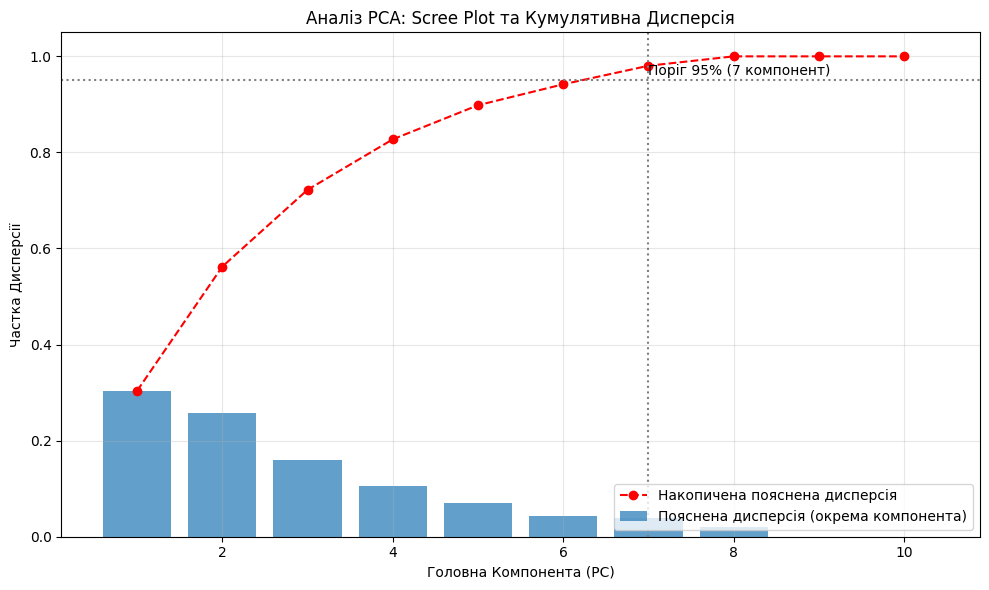


Оптимальна k для 95% дисперсії: 7


In [ ]:
n = X_scaled.shape[0]
cov_mat = (X_scaled.T @ X_scaled) / (n - 1)
eigvals, eigvecs = np.linalg.eigh(cov_mat)
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
explained_variance_ratio = eigvals / eigvals.sum()
evr = explained_variance_ratio
cum_evr = np.cumsum(evr)
n_components = len(evr)
n_components_95 = np.argmax(cum_evr >= 0.95) + 1
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), evr, alpha=0.7, label='Пояснена дисперсія (окрема компонента)')
plt.plot(range(1, n_components + 1), cum_evr, marker='o', color='red',
         linestyle='--', label='Накопичена пояснена дисперсія')
plt.axhline(0.95, linestyle=':', linewidth=1.5, color='gray')
plt.text(n_components * 0.7, 0.955, f'Поріг 95% ({n_components_95} компонент)',
         va='bottom', color='black', fontsize=10)
plt.axvline(n_components_95, color='gray', linestyle=':', linewidth=1.5)
plt.xlabel('Головна Компонента (PC)')
plt.ylabel('Частка Дисперсії')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.title('Аналіз PCA: Scree Plot та Кумулятивна Дисперсія')
plt.tight_layout()
plt.show()

print(f"\nОптимальна k для 95% дисперсії: {n_components_95}")

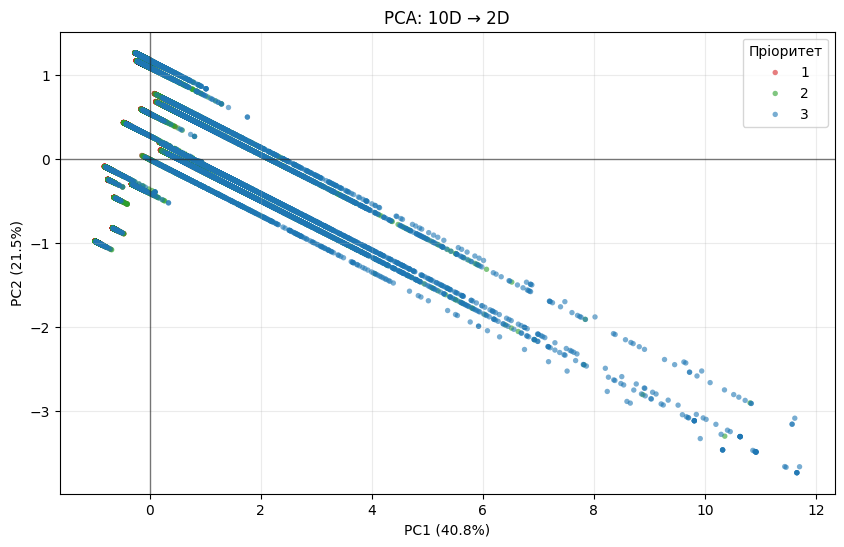

In [ ]:
from sklearn.manifold import TSNE
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pc1, pc2 = X_pca[:, 0], X_pca[:, 1]
explained_variance_pc1 = pca.explained_variance_ratio_[0]
explained_variance_pc2 = pca.explained_variance_ratio_[1]
sample_size = 5000
np.random.seed(42)
total_samples = X_scaled.shape[0]
sample_indices = np.random.choice(total_samples, size=sample_size, replace=False)

X_sample = X_scaled[sample_indices]
y_sample_encoded = y_encoded[sample_indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_sample)
tsne1, tsne2 = X_tsne[:, 0], X_tsne[:, 1]
n_classes = len(priorities)
y = y_encoded
plt.figure(figsize=(10, 6))
ax = plt.gca()
for cls, name, c in zip(range(n_classes), priorities, colors):
    idx = (y == cls)
    ax.scatter(pc1[idx], pc2[idx], label=name, c=c, s=15, edgecolor='none', alpha=0.6)
ax.axhline(0, linewidth=1, color='black', alpha=0.5)
ax.axvline(0, linewidth=1, color='black', alpha=0.5)
ax.set_xlabel(f'PC1 ({explained_variance_pc1*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_variance_pc2*100:.1f}%)')
ax.set_title(f'PCA: {X_scaled.shape[1]}D → 2D')
ax.legend(title="Пріоритет")
ax.grid(True, alpha=0.25)


In [ ]:
optimal_k = 8
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)
model_full = LogisticRegression(max_iter=1000, random_state=42)
start_time_full = time.time()
model_full.fit(X_train_full, y_train)
time_full = time.time() - start_time_full
accuracy_full = model_full.score(X_test_full, y_test)
pca_optimized = PCA(n_components=optimal_k, random_state=42)
X_train_pca = pca_optimized.fit_transform(X_train_full)
X_test_pca = pca_optimized.transform(X_test_full)
model_pca = LogisticRegression(max_iter=1000, random_state=42)
start_time_pca = time.time()
model_pca.fit(X_train_pca, y_train)
time_pca = time.time() - start_time_pca
accuracy_pca = model_pca.score(X_test_pca, y_test)
print("\n--- ПОРІВНЯННЯ РЕЗУЛЬТАТІВ КЛАСИФІКАЦІЇ (Logistic Regression) ---")
print(f"Початкова розмірність: {X_scaled.shape[1]}D")
print(f"PCA розмірність: {optimal_k}D (Збережено 95% дисперсії)")
print("----------------------------------------------------------------------")
print(f"1. Повні дані (14D): Точність={accuracy_full:.4f}, Час={time_full:.4f} сек")
print(f"2. Зменшені дані (9D): Точність={accuracy_pca:.4f}, Час={time_pca:.4f} сек")
print("----------------------------------------------------------------------")
print(f"Зміна точності: {accuracy_pca - accuracy_full:.4f}")
print(f"Прискорення навчання: {time_full / time_pca:.1f} разів")


--- ПОРІВНЯННЯ РЕЗУЛЬТАТІВ КЛАСИФІКАЦІЇ (Logistic Regression) ---
Початкова розмірність: 10D
PCA розмірність: 8D (Збережено 95% дисперсії)
----------------------------------------------------------------------
1. Повні дані (14D): Точність=0.6808, Час=0.3937 сек
2. Зменшені дані (9D): Точність=0.6812, Час=0.5500 сек
----------------------------------------------------------------------
Зміна точності: 0.0004
Прискорення навчання: 0.7 разів


# K-means Clustering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans
from sklearn import set_config
set_config(display='text')

Image shape: (1080, 1080, 3)
dtype: float32


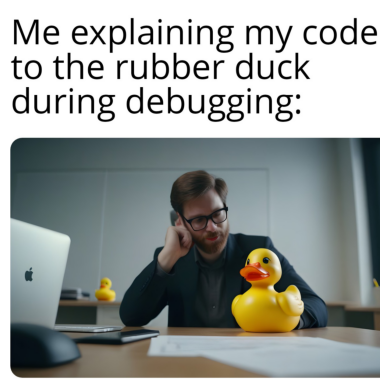

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
file_name = "duck2.png"
img = mpimg.imread(file_name)
H, W, C = img.shape
print("Image shape:", img.shape)
print("dtype:", img.dtype)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
pixels = img.reshape(-1, 3)
k = 64  # кількість кольорів
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_clusters=64, n_init=10, random_state=0)

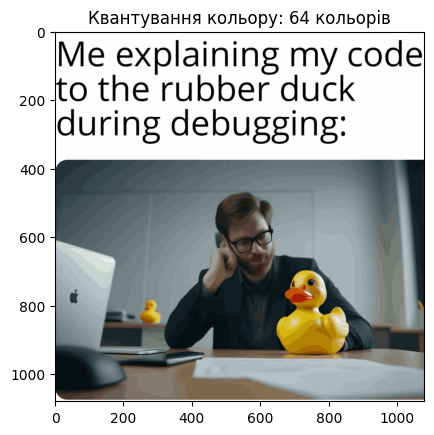

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)
plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 64


In [ ]:
pixels = img.reshape(-1, 3)
k = 32
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_clusters=32, n_init=10, random_state=0)

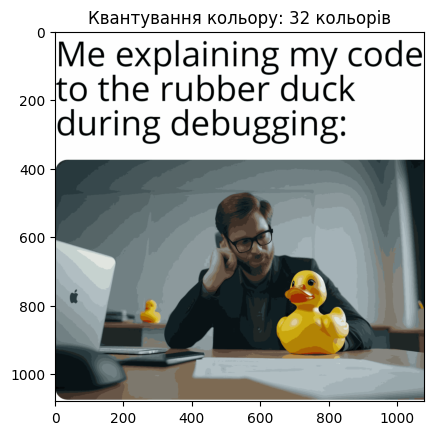

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)
plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 32


In [ ]:

pixels = img.reshape(-1, 3)
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_clusters=16, n_init=10, random_state=0)

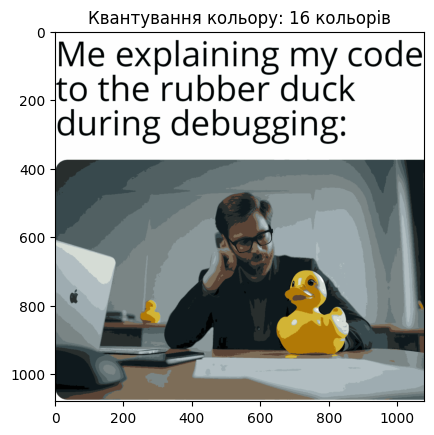

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)
plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 16


In [ ]:

pixels = img.reshape(-1, 3)k = 8  # кількість кольорів
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_init=10, random_state=0)

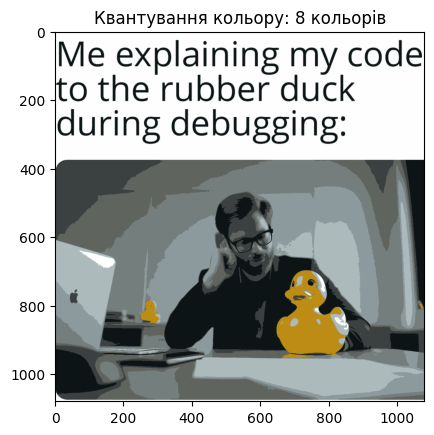

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)

plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 8


# Обробка та класифікація текстових даних

In [64]:
import pandas as pd
import simplejson
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gzip
import simplejson
import os

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

def parse(filename):
    try:
        f = open(filename, 'r', encoding='latin-1')
    except Exception:
        f = open(filename, 'r', encoding='utf-8')

    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            if entry:
                yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest

    if entry:
        yield entry
    f.close()

FILE_NAME = "first_100000.txt"
all_entries = []

for e in parse(FILE_NAME):
    if 'review/text' in e and 'review/score' in e:
        all_entries.append(e)

df = pd.DataFrame(all_entries)
def get_sentiment(score):
    score = float(score)
    if score >= 4.0:
        return 'positive' # 4.0, 5.0
    elif score == 3.0:
        return 'neutral'  # 3.0
    else:
        return 'negative' # 1.0, 2.0

df['sentiment'] = df['review/score'].apply(get_sentiment)
df_text = pd.DataFrame({
    'text': df['review/text'].astype(str),
    'score': df['review/score'].astype(float),
    'category': df['sentiment']
})

print(f"Розмір текстового датасету: {df_text.shape}")
print(df_text['category'].value_counts())

Розмір текстового датасету: (9091, 3)
category
positive    6729
negative    1521
neutral      841
Name: count, dtype: int64


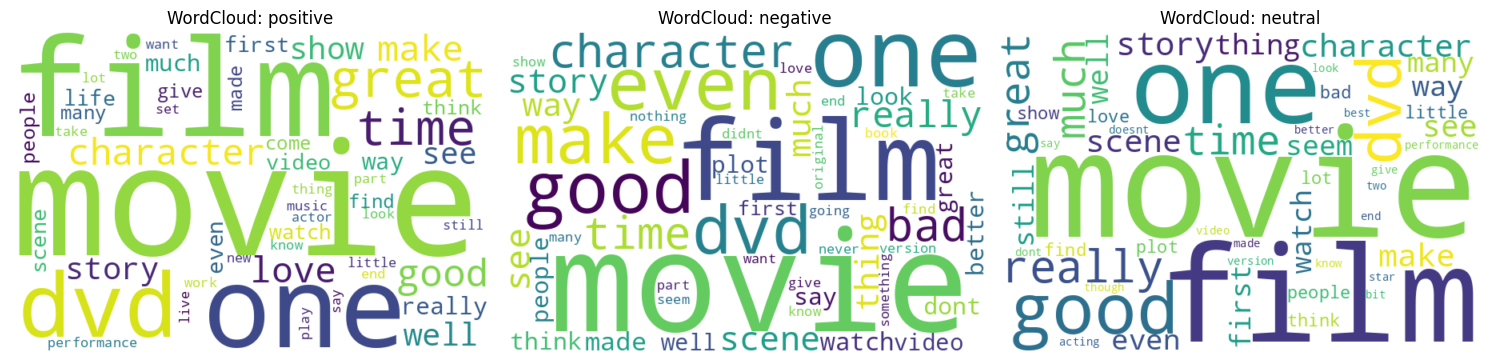

In [65]:
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower().strip()

    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 2]

    return ' '.join(words)

df_text['cleaned_text'] = df_text['text'].apply(clean_text)
df_text = df_text[df_text['cleaned_text'].str.len() > 50]

plt.figure(figsize=(15, 7))
for i, category in enumerate(df_text['category'].unique()):
    text = ' '.join(df_text[df_text['category'] == category]['cleaned_text'])
    wordcloud = WordCloud(width=600, height=400, background_color='white',
                         max_words=50).generate(text)
    plt.subplot(1, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud: {category}')
    plt.axis('off')
plt.tight_layout()
plt.show()


Точність класифікації текстів: 0.7975
              precision    recall  f1-score   support

    positive       0.79      0.41      0.54       444
    negative       1.00      0.04      0.07       263
     neutral       0.80      0.99      0.88      1960

    accuracy                           0.80      2667
   macro avg       0.86      0.48      0.50      2667
weighted avg       0.82      0.80      0.75      2667



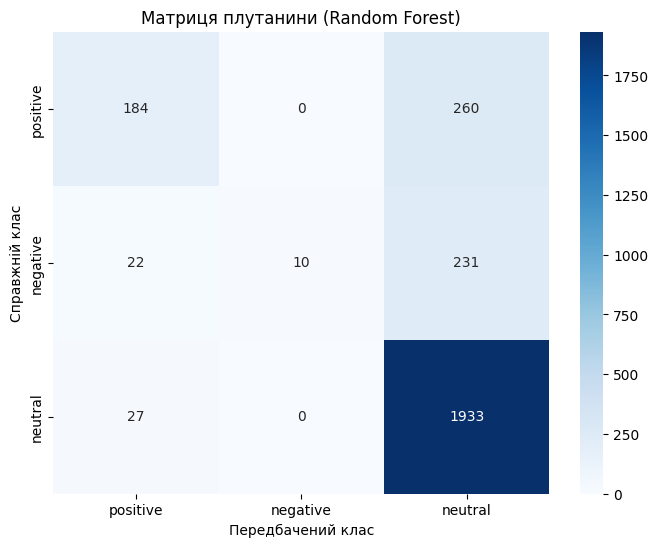

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = vectorizer.fit_transform(df_text['cleaned_text'])
y_text = df_text['category']

X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.3, random_state=42)

rf_text = RandomForestClassifier(n_estimators=100, random_state=42)
rf_text.fit(X_train, y_train)
text_score = rf_text.score(X_test, y_test)

print(f"Точність класифікації текстів: {text_score:.4f}")
print(classification_report(y_test, rf_text.predict(X_test),
                          target_names=df_text['category'].unique()))
class_names = df_text['category'].unique()

try:
    cm = confusion_matrix(y_test, rf_text.predict(X_test))
except NameError as e:
    print(f"Помилка: {e}. Переконайтеся, що модель (rf_text) та тестові дані (y_test, X_test) існують.")
    raise
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Матриця плутанини (Random Forest)')
plt.xlabel('Передбачений клас')
plt.ylabel('Справжній клас')
plt.show()
